#Running MSAF#

The main MSAF functionality is demonstrated here.

In [ ]:
from __future__ import print_function
import msaf
import librosa
import seaborn as sns

# and IPython.display for audio output
import IPython.display

# Setup nice plots
sns.set(style="dark")
%matplotlib inline

## Single File Mode ##

This mode analyzes one audio file at a time.

In [ ]:
# Choose an audio file and listen to it
audio_file = "../datasets/Sargon/audio/01-Sargon-Mindless.mp3"
IPython.display.Audio(filename=audio_file)

In [33]:
# Segment the file using the default MSAF parameters
boundaries, labels = msaf.process(audio_file)
print(boundaries)

[   0.            7.89478458   32.78657596   46.02195011   79.18004535
   90.65070295  112.70965986  129.42802721  142.94204082  154.41269841
  168.06603175  181.02276644  193.00426304  208.09723356  221.37904762
  234.15002268  288.48471655  317.04526077  330.00199546  344.90920635
  377.04562358  390.46675737  403.56281179  409.089161    414.14530612]


In [ ]:
# Sonify boundaries
sonified_file = "my_boundaries.wav"
sr = 44100
boundaries, labels = msaf.process(audio_file, sonify_bounds=True, 
                                  out_bounds=sonified_file, out_sr=sr)

# Listen to results
audio = librosa.load(sonified_file, sr=sr)[0]
IPython.display.Audio(audio, rate=sr)

### Using different Algorithms ###

MSAF includes multiple algorithms both for boundary retrieval and structural grouping (or labeling). In this section we demonstrate how to try them out.

Note: more algorithms are available in [msaf-gpl](https://github.com/urinieto/msaf-gpl).

In [34]:
# First, let's list all the available boundary algorithms
print(msaf.get_all_boundary_algorithms())

['cnmf', 'foote', 'olda', 'scluster', 'sf']


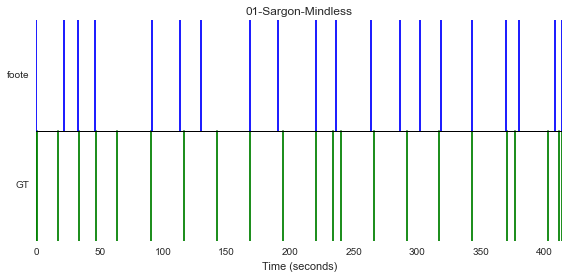

In [35]:
# Try one of these boundary algorithms and print results
boundaries, labels = msaf.process(audio_file, boundaries_id="foote", plot=True)

In [36]:
# Let's check all the structural grouping (label) algorithms available
print(msaf.get_all_label_algorithms())

['cnmf', 'fmc2d', 'scluster']


In [37]:
# Try one of these label algorithms
boundaries, labels = msaf.process(audio_file, boundaries_id="foote", labels_id="fmc2d")
print(boundaries)
print(labels)

[   0.           22.01251701   33.20453515   46.48634921   91.06866213
  113.12761905  129.84598639  168.43755102  190.58938776  220.49668934
  236.51845805  264.01088435  286.85931973  302.64888889  318.6706576
  343.51600907  369.94031746  380.43573696  409.089161    414.14530612]
[4, 4, 4, 3, 4, 4, 2, 4, 0, 4, 4, 1, 4, 4, 0, 5, 4, 0, 6]


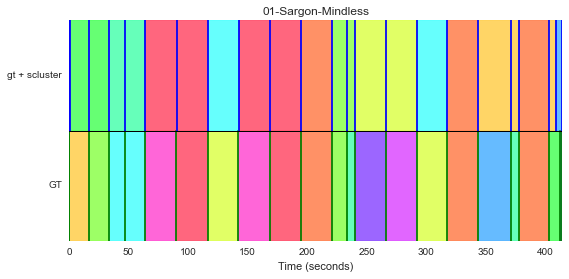

In [38]:
# If available, you can use previously annotated boundaries and a specific labels algorithm
# Set plot = True to plot the results
boundaries, labels = msaf.process(audio_file, boundaries_id="gt", 
                                  labels_id="scluster", plot=True)

### Using different Features ###

Some algorithms allow the input of different type of features (e.g., harmonic, timbral). In this section we show how we can input different features to MSAF.

In [39]:
# Let's check what available features are there in MSAF
print(msaf.AVAILABLE_FEATS)

['hpcp', 'mfcc', 'cqt', 'tonnetz']


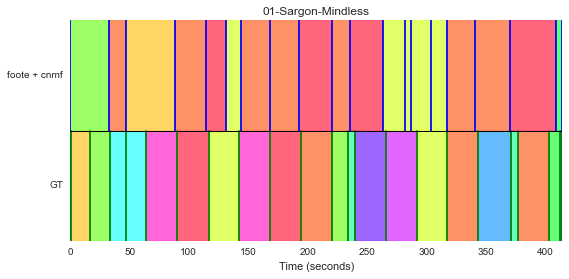

In [40]:
# Segment the file using the Foote method for boundaries, C-NMF method for labels, and MFCC features
boundaries, labels = msaf.process(audio_file, feature="mfcc", boundaries_id="foote", 
                                  labels_id="cnmf", plot=True)

### Evaluate Results ###

The results can be evaluated as long as there is an existing file containing reference annotations. The results are stored in a pandas DataFrame. MSAF has to run these algorithms (using `msaf.process` described above) before being able to evaluate its results.

In [41]:
# Evaluate the results. It returns a pandas data frame.
evaluations = msaf.eval.process(audio_file, boundaries_id="foote", labels_id="fmc2d")
IPython.display.display(evaluations)

,D,DevE2R,DevR2E,DevtE2R,DevtR2E,HitRate_0.5F,HitRate_0.5P,HitRate_0.5R,HitRate_3F,HitRate_3P,...,HitRate_t3P,HitRate_t3R,PWF,PWP,PWR,Sf,So,Su,ds_name,track_id
0,0.470375,1.71449,1.896168,2.401961,2.909297,0.325581,0.35,0.304348,0.604651,0.65,...,0.611111,0.52381,0.420751,0.290074,0.76569,0.641772,0.807684,0.532406,01-Sargon-Mindless.jams,01-Sargon-Mindless


### Explore Algorithm Parameters ###

Now let's modify the configuration of one of the files, and modify it to see how different the results are.
We will use Widgets, which will become handy here.

In [42]:
# First, check which are foote's algorithm parameters:
print(msaf.algorithms.foote.config)

{'L_peaks': 64, 'm_median': 12, 'M_gaussian': 96}


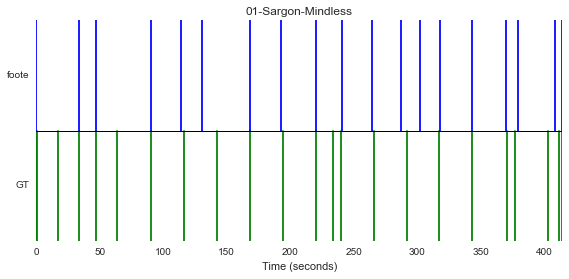

,D,DevE2R,DevR2E,DevtE2R,DevtR2E,HitRate_0.5F,HitRate_0.5P,HitRate_0.5R,HitRate_3F,HitRate_3P,HitRate_3R,HitRate_t0.5F,HitRate_t0.5P,HitRate_t0.5R,HitRate_t3F,HitRate_t3P,HitRate_t3R,ds_name,track_id
0,0.495857,1.114853,1.266984,1.266984,1.739093,0.380952,0.421053,0.347826,0.761905,0.842105,0.695652,0.315789,0.352941,0.285714,0.736842,0.823529,0.666667,01-Sargon-Mindless.jams,01-Sargon-Mindless


In [43]:
# play around with IPython.Widgets
from IPython.html.widgets import interact

# Obtain the default configuration
bid = "foote"  # Boundaries ID
lid = None     # Labels ID
feature = "hpcp"
config = msaf.io.get_configuration(feature, annot_beats=False, framesync=False, 
                                   boundaries_id=bid, labels_id=lid)

# Sweep M_gaussian parameters
@interact(M_gaussian=(50, 500, 25))
def _run_msaf(M_gaussian):
    # Set the configuration
    config["M_gaussian"] = M_gaussian
    
    # Segment the file using the Foote method, and Pitch Class Profiles for the features
    results = msaf.process(audio_file, feature=feature, boundaries_id=bid, 
                           config=config, plot=True)

    # Evaluate the results. It returns a pandas data frame.
    evaluations = msaf.eval.process(audio_file, feature=feature, boundaries_id=bid,
                                    config=config)
    IPython.display.display(evaluations)

## Collection Mode ##

MSAF is able to run and evaluate mutliple files using multi-threading. In this section we show this functionality.

In [44]:
dataset = "../datasets/Sargon/"
results = msaf.process(dataset, n_jobs=4, boundaries_id="foote")

In [45]:
# Evaluate in collection mode
evaluations = msaf.eval.process(dataset, n_jobs=4, boundaries_id="foote")
IPython.display.display(evaluations)

,D,DevE2R,DevR2E,DevtE2R,DevtR2E,HitRate_0.5F,HitRate_0.5P,HitRate_0.5R,HitRate_3F,HitRate_3P,HitRate_3R,HitRate_t0.5F,HitRate_t0.5P,HitRate_t0.5R,HitRate_t3F,HitRate_t3P,HitRate_t3R,ds_name,track_id
0,0.470375,1.714490,1.896168,2.401961,2.909297,0.325581,0.35000,0.304348,0.604651,0.650000,0.565217,0.256410,0.277778,0.238095,0.564103,0.611111,0.523810,01-Sargon-Mindless.jams,01-Sargon-Mindless
1,0.437517,1.313379,1.618277,1.535261,1.724082,0.222222,0.25000,0.200000,0.800000,0.900000,0.720000,0.146341,0.166667,0.130435,0.780488,0.888889,0.695652,02-Sargon-Shattered World.jams,02-Sargon-Shattered World
2,0.448502,0.504501,12.046519,0.868719,12.243039,0.263158,0.50000,0.178571,0.473684,0.900000,0.321429,0.176471,0.375000,0.115385,0.411765,0.875000,0.269231,03-Sargon-Waiting For Silence.jams,03-Sargon-Waiting For Silence
3,0.318680,1.046576,1.175283,1.064331,1.271236,0.256881,0.27451,0.241379,0.660550,0.705882,0.620690,0.228571,0.244898,0.214286,0.647619,0.693878,0.607143,04-Sargon-The Curse Of Akkad.jams,04-Sargon-The Curse Of Akkad
